In [1]:
import os.path

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
batch_size = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

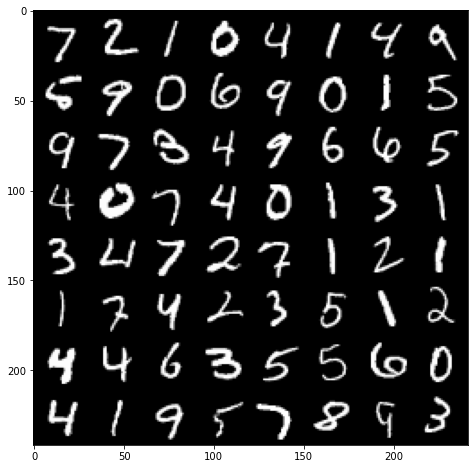

In [4]:
plt.figure(figsize=(8, 8))
iter_dataloader = iter(test_dataloader)

n=1

# 取出n*batch_size张图片可视化
for i in range(n):
    images, labels = next(iter_dataloader)
    image_grid = torchvision.utils.make_grid(images)
    plt.subplot(1, n, i+1)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,3,stride=1,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5,stride=1,padding=1),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(576,120),
            nn.Linear(120,84),
            nn.Linear(84,10)
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [7]:
def train(network):

    losses = []
    iteration = 0

    epochs = 10

    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = loss_sum / len(train_dataloader.dataset)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")

    # 绘制损失函数曲线
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.plot(list(range(iteration)), losses)

In [8]:
network = LeNet()
network.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)

if os.path.exists('model.pth'):
    network.load_state_dict(torch.load('model.pth'))
else:
    train(network)

In [9]:
positive = 0
negative = 0
for X, y in test_dataloader:
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        pred = network(X)
        for item in zip(pred, y):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1
acc = positive / (positive + negative)
print(f"Accuracy: {acc * 100}%")

Accuracy: 97.69%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


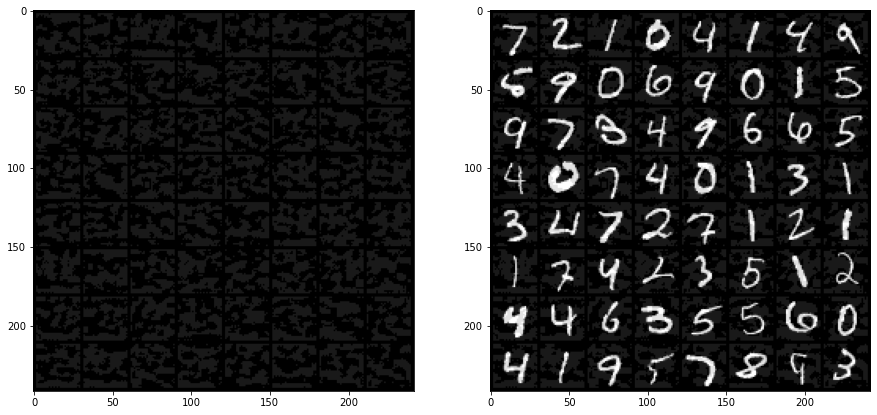

In [10]:
# 寻找对抗样本，并可视化

eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)

    X.requires_grad = True
    pred = network(X)
    network.zero_grad()
    loss = loss_fn(pred, y)
    loss.backward()

    plt.figure(figsize=(15, 8))

    plt.subplot(121)
    image_grid = torchvision.utils.make_grid(torch.clamp(X.grad.sign(), -0.1, 0.1))
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))

    X_adv = X + eps[2] * X.grad.sign()
    X_adv = torch.clamp(X_adv, 0, 1)

    plt.subplot(122)
    image_grid = torchvision.utils.make_grid(X_adv)
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))

    break

epsilon=0.01 acc: 96.7%
epsilon=0.05 acc: 92.25999999999999%
epsilon=0.1 acc: 81.28%
epsilon=0.2 acc: 62.419999999999995%
epsilon=0.3 acc: 50.044%
epsilon=0.4 acc: 41.74166666666667%
epsilon=0.5 acc: 35.79571428571428%
epsilon=0.6 acc: 31.33375%
epsilon=0.7 acc: 27.868888888888886%
epsilon=0.8 acc: 25.11%


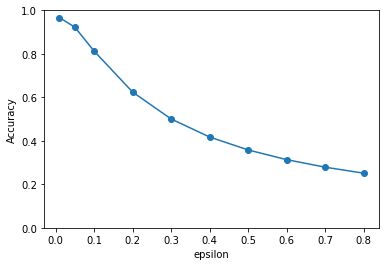

In [11]:
# 用对抗样本替代原始样本，测试准确度
# 探究不同epsilon对LeNet分类准确度的影响
positive = 0
negative = 0
acc_list = []
for epsilon in eps:

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        X.requires_grad = True
        pred = network(X)
        network.zero_grad()
        loss = loss_fn(pred, y)
        loss.backward()

        X = X + epsilon * X.grad.sign()
        X_adv = torch.clamp(X, 0, 1)

        pred = network(X_adv)
        for item in zip(pred, y):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1

    acc = positive / (positive + negative)
    print(f"epsilon={epsilon} acc: {acc * 100}%")
    acc_list.append(acc)

plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.plot(eps, acc_list, marker='o')